<a href="https://colab.research.google.com/github/MadMax1995bb/powder_alert2.0/blob/master/notebook_Anita_Gei_snowdepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Snowdepth with TransformerModel

## 1. Imports

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.0 MB/s eta 0:00:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import Callback

from darts import TimeSeries
from darts.models import TransformerModel, BlockRNNModel
from darts.metrics import mae, mape
from darts.utils.likelihood_models import GaussianLikelihood

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Getting Started
## Import basic preprocessed dataset | all features scaled, target (snow_depth) not scaled!

In [ ]:
# for future reference - get data directly from api?
# fetch_weather_data()

In [ ]:
# in the meantime use preprocessed csv (refer to notebook_Anita-Gei_get_preprocessed_data.ipynb for more info)

df = pd.read_csv('/content/historical_data_preprocessed_snowdepth.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.drop(columns='Unnamed: 0')
df = df.set_index('date')
df.tail(2)

,snow_depth,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snowfall,pressure_msl,surface_pressure,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,1.23,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,-0.289634,-0.129623,-1.404447,...,-0.413650,-0.063053,-0.097270,-0.565147,-0.500000,0.866025,0.0,1.0,0.0,1.0
2024-01-01 23:00:00,1.23,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,-0.289634,-0.280686,-1.495166,...,-0.427446,-0.142219,-0.044957,-0.565147,-0.258819,0.965926,0.0,1.0,0.0,1.0


## Create Time Series

In [ ]:
feature_columns = df.drop(columns=['snow_depth']).columns.tolist()

snowfall_series = TimeSeries.from_dataframe(df, value_cols='snow_depth')
feature_series = TimeSeries.from_dataframe(df, value_cols=feature_columns)

## Split into Train, Validation and Test Sets

In [ ]:
y_train_val, y_test = snowfall_series.split_before(0.8)
y_train, y_val = y_train_val.split_before(0.8)

X_train_val, X_test = feature_series.split_before(0.8)
X_train, X_val = X_train_val.split_before(0.8)

# Try TransformerModel without Optimization

In [ ]:
early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=12, verbose=True)
callbacks = [early_stopper]

pl_trainer_kwargs ={
        "callbacks": callbacks,
    }

new_model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    batch_size=64,
    n_epochs=100,  # stopped after epoch 15 with es
    pl_trainer_kwargs=pl_trainer_kwargs)

In [ ]:
new_model.fit(series=y_train, past_covariates=X_train, val_series=y_val, val_past_covariates=X_val, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.003. Signaling Trainer to stop.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=48, batch_size=64, n_epochs=100, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7b9a5efb1270>]})

In [ ]:
new_model.save('/content/snow_depth_model_1.pt')

   -----------------------------------------------------------------------------

In [ ]:
forecast_test48h = new_model.predict(n=48, series=y_train_val, past_covariates=X_train_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
forecast_test48h.values()

array([[0.9166504 ],
       [0.91651427],
       [0.91763704],
       [0.91739297],
       [0.91760078],
       [0.91934583],
       [0.91969401],
       [0.92094861],
       [0.92301323],
       [0.92456152],
       [0.92718892],
       [0.92663534],
       [0.9286992 ],
       [0.93020679],
       [0.93179403],
       [0.93385039],
       [0.93671479],
       [0.93914202],
       [0.93988239],
       [0.94177533],
       [0.94111546],
       [0.94211855],
       [0.94263282],
       [0.9436318 ],
       [0.94543821],
       [0.94569478],
       [0.94674942],
       [0.94815157],
       [0.94882901],
       [0.94889109],
       [0.94988814],
       [0.950289  ],
       [0.95033397],
       [0.95194112],
       [0.952622  ],
       [0.95255938],
       [0.9530358 ],
       [0.95418537],
       [0.95464273],
       [0.95568884],
       [0.95788795],
       [0.95857194],
       [0.96048188],
       [0.96140365],
       [0.9650528 ],
       [0.96579539],
       [0.96573119],
       [0.966

In [ ]:
mae_new = mae(snowfall_series.slice_intersect(forecast_test48h), forecast_test48h)
mae_new

0.059984269951968074

In [ ]:
historical_forecast_new = new_model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowfall_series.slice_intersect(historical_forecast_new), historical_forecast_new)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

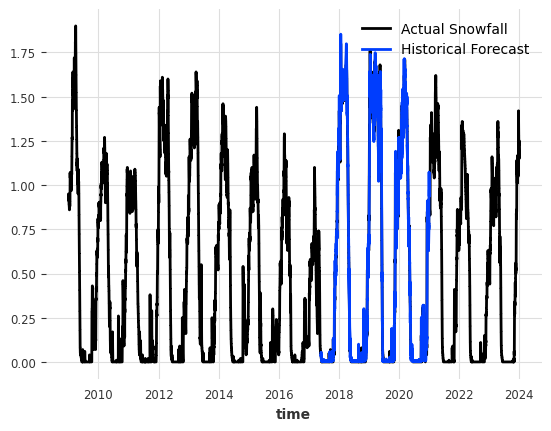

In [ ]:
snowfall_series.plot(label="Actual Snowfall")
historical_forecast_new.plot(label="Historical Forecast")
plt.legend()
plt.show();

In [ ]:
backtest_mae_new = new_model.backtest(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    metric=mae,
    verbose=True
)

print(f"Backtest MAE: {backtest_mae_new}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest MAE: 0.024497823196316836


## Load Model

In [ ]:
loaded_model = TransformerModel.load("/content/snow_depth_model_1.pt")

/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

In [ ]:
historical_forecast_loaded = loaded_model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowfall_series.slice_intersect(historical_forecast_new), historical_forecast_new)
error_mae

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

0.03249186121957923

# Try without Early Stopping (to be able to retrain later)

In [ ]:
#without early stopping
pl_trainer_kwargs ={
        "accelerator": "gpu", #only on Colab!
        "devices": -1,
        #"callbacks": callbacks,
    }

model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    batch_size=64,
    n_epochs=50,
    pl_trainer_kwargs=pl_trainer_kwargs)

model.fit(series=y_train, past_covariates=X_train, val_series=y_val, val_past_covariates=X_val, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=48, batch_size=64, n_epochs=50, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1})

In [ ]:
historical_forecast = model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowfall_series.slice_intersect(historical_forecast_new), historical_forecast_new)
print(error_mae)

snowfall_series.plot(label="Actual Snowfall")
historical_forecast_new.plot(label="Historical Forecast")
plt.legend()
plt.show();

NameError: name 'model' is not defined

In [ ]:
backtest_mae = model.backtest(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=365*5+1,
    retrain=True,
    metric=mae,
    verbose=True
)

print(f"Backtest MAE: {backtest_mae_new}")


  0%|          | 0/18 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             |

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
  0%|          | 0/18 [14:47<?, ?it/s]


NameError: name 'exit' is not defined

# Improving Model Performance | Target = Snowfall  ==> OR NOT

## Feature Engineering

In [ ]:
# Create lag features for snowfall and precipitation
lags = [1, 3]
for lag in lags:
    df[f'snowfall_lag_{lag}'] = df['snowfall'].shift(lag)
    df[f'precipitation_lag_{lag}'] = df['precipitation'].shift(lag)

df.tail()

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,snowfall_lag_1,precipitation_lag_1,snowfall_lag_3,precipitation_lag_3
date,,,,,,,,,,,,,,,,,,,,,
2022-03-14 08:00:00,0.0,3.0,-0.144176,-2.126533,-1.118233,-0.389763,-0.272938,1.178280,1.368418,0.994678,...,0.866025,-0.500000,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763
2022-03-14 09:00:00,0.0,2.0,0.042154,-2.360580,-1.099278,-0.389763,-0.272938,1.178280,1.318064,1.079167,...,0.707107,-0.707107,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763
2022-03-14 10:00:00,0.0,1.0,0.192421,-2.493189,-1.055049,-0.389763,-0.272938,1.178280,1.267709,1.138710,...,0.500000,-0.866025,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763
2022-03-14 11:00:00,0.0,3.0,0.246517,-1.929069,-0.619078,-0.389763,-0.272938,1.159507,1.255121,1.164308,...,0.258819,-0.965926,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763
2022-03-14 12:00:00,0.0,1.0,0.438858,-2.839331,-1.111915,-0.389763,-0.272938,1.159507,1.129235,1.190595,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.389763,0.0,-0.389763


In [ ]:
# Add rolling statistics
df['cloud_cover_rolling_mean_3h'] = df['cloud_cover'].rolling(window=3).mean()
df['precipitation_rolling_std_3h'] = df['precipitation'].rolling(window=3).std()
df.tail(2)

,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,day_of_week_sin,day_of_week_cos,month_sin,month_cos,snowfall_lag_1,precipitation_lag_1,snowfall_lag_3,precipitation_lag_3,cloud_cover_rolling_mean_3h,precipitation_rolling_std_3h
date,,,,,,,,,,,,,,,,,,,,,
2022-03-14 11:00:00,0.0,3.0,0.246517,-1.929069,-0.619078,-0.389763,-0.272938,1.159507,1.255121,1.164308,...,0.0,1.0,0.866025,0.5,0.0,-0.389763,0.0,-0.389763,-0.232365,0.0
2022-03-14 12:00:00,0.0,1.0,0.438858,-2.839331,-1.111915,-0.389763,-0.272938,1.159507,1.129235,1.190595,...,NaN,NaN,NaN,NaN,0.0,-0.389763,0.0,-0.389763,-0.485142,0.0


In [ ]:
# Drop rows with NaN values (introduced by lags and rolling)
df = df.dropna()
print(df.shape)

(115689, 34)


## Use Subset of Data while finding the "best" Model!

In [ ]:
train_df = df[-30000:]
print(train_df.shape)
train_df.tail(2)

(30000, 28)


,snowfall,weather_code_encoded,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,rain,snow_depth,pressure_msl,surface_pressure,...,wind_direction_10m,wind_direction_100m,wind_gusts_10m,sunshine_duration,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01 22:00:00,0.0,3.0,-1.911309,0.072451,-1.882762,-0.389763,-0.272938,1.403548,-0.129623,-1.404447,...,-0.413650,-0.063053,-0.097270,-0.565147,-0.500000,0.866025,0.0,1.0,0.0,1.0
2024-01-01 23:00:00,0.0,1.0,-1.875245,-0.040464,-1.882762,-0.389763,-0.272938,1.403548,-0.280686,-1.495166,...,-0.427446,-0.142219,-0.044957,-0.565147,-0.258819,0.965926,0.0,1.0,0.0,1.0


## Optimize Hyperparamters with Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna

#from optuna.integration import PyTorchLightningPruningCallback  ## -- causes error --> workaround suggested on  https://github.com/optuna/optuna-examples/issues/166#issuecomment-1403112861
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Workaround to get PyTorchLightningPruningCallback working

class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

In [ ]:
def objective(trial):
    d_model = trial.suggest_categorical("d_model", [128, 256, 512])
    nhead = trial.suggest_categorical("nhead", [4, 8])
    dropout = trial.suggest_categorical("dropout", [0.1, 0.2, 0.3])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_encoder_layers = trial.suggest_categorical("num_encoder_layers", [2, 3, 6])
    num_decoder_layers = trial.suggest_categorical("num_decoder_layers", [2, 3, 6])
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [256, 512, 1024])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    # throughout training we'll monitor the validation loss for both pruning and early stopping
    pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=12, verbose=True)
    callbacks = [pruner, early_stopper]

    # detect if a GPU is available
    if torch.cuda.is_available():
        num_workers = 4
    else:
        num_workers = 0

    pl_trainer_kwargs = {
        "accelerator": "gpu", #only on Colab!
        "devices": -1,
        "callbacks": callbacks,
    }

    # reproducibility
    torch.manual_seed(42)

    # build the Transformer model
    model = TransformerModel(
        input_chunk_length=48,
        output_chunk_length=48,
        batch_size=batch_size,
        n_epochs=100,
        nr_epochs_val_period=1,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=dim_feedforward,
        pl_trainer_kwargs=pl_trainer_kwargs,
        likelihood=GaussianLikelihood(),
        model_name="trf_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # train the model
    model.fit(
        series=y_train,
        past_covariates=X_train,
        val_series=y_val,
        val_past_covariates=X_val,
    )

    # reload best model over course of training
    model = TransformerModel.load_from_checkpoint("trf_model")

    # Evaluate how good it is on the validation set, using sMAPE
    preds = model.predict(series=y_train, n=48)
    maes = mae(y_val[:48], preds, n_jobs=-1, verbose=True)
    mae_val = np.mean(maes)

    return mae_val if mae_val != np.nan else float("inf")


# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by minimizing the maes on the validation set
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10, callbacks=[print_callback])

[I 2024-12-18 08:16:04,810] A new study created in memory with name: no-name-89149bd9-b58f-4e7e-9b1c-3d170fc2eb0d
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.045


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.045. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

Predicting: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 544.93it/s]
[I 2024-12-18 08:21:31,067] Trial 0 finished with value: 0.08309882464897507 and parameters: {'d_model': 128, 'nhead': 4, 'dropout': 0.2, 'batch_size': 32, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 1024, 'lr': 0.00017126742907045333}. Best is trial 0 with value: 0.08309882464897507.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.

Current value: 0.08309882464897507, Current params: {'d_model': 128, 'nhead': 4, 'dropout': 0.2, 'batch_size': 32, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 1024, 'lr': 0.00017126742907045333}
Best value: 0.08309882464897507, Best params: {'d_model': 128, 'nhead': 4, 'dropout': 0.2, 'batch_size': 32, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 1024, 'lr': 0.00017126742907045333}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: -0.111


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: -0.111. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Predicting: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 528.45it/s]
[I 2024-12-18 08:30:14,956] Trial 1 finished with value: 0.08512658609966921 and parameters: {'d_model': 128, 'nhead': 4, 'dropout': 0.2, 'batch_size': 16, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'lr': 0.00017657222015739826}. Best is trial 0 with value: 0.08309882464897507.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.m

Current value: 0.08512658609966921, Current params: {'d_model': 128, 'nhead': 4, 'dropout': 0.2, 'batch_size': 16, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'lr': 0.00017657222015739826}
Best value: 0.08309882464897507, Best params: {'d_model': 128, 'nhead': 4, 'dropout': 0.2, 'batch_size': 32, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 1024, 'lr': 0.00017126742907045333}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.262


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.161 >= min_delta = 0.001. New best score: 0.102


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.084


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.082


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.066


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.066. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

Predicting: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 573.07it/s]
[I 2024-12-18 08:36:01,705] Trial 2 finished with value: 0.22713367846081875 and parameters: {'d_model': 256, 'nhead': 8, 'dropout': 0.2, 'batch_size': 32, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.004133584619475779}. Best is trial 0 with value: 0.08309882464897507.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.mod

Current value: 0.22713367846081875, Current params: {'d_model': 256, 'nhead': 8, 'dropout': 0.2, 'batch_size': 32, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.004133584619475779}
Best value: 0.08309882464897507, Best params: {'d_model': 128, 'nhead': 4, 'dropout': 0.2, 'batch_size': 32, 'num_encoder_layers': 2, 'num_decoder_layers': 6, 'dim_feedforward': 1024, 'lr': 0.00017126742907045333}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.009. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

Predicting: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 492.12it/s]
[I 2024-12-18 08:38:25,374] Trial 3 finished with value: 0.07701035510933062 and parameters: {'d_model': 128, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'lr': 0.0003878343583696382}. Best is trial 3 with value: 0.07701035510933062.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.mo

Current value: 0.07701035510933062, Current params: {'d_model': 128, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'lr': 0.0003878343583696382}
Best value: 0.07701035510933062, Best params: {'d_model': 128, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'lr': 0.0003878343583696382}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.126


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 0.071


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 0.071. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

Predicting: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 523.11it/s]
[I 2024-12-18 08:46:18,783] Trial 4 finished with value: 0.2638862811487695 and parameters: {'d_model': 128, 'nhead': 4, 'dropout': 0.3, 'batch_size': 16, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.007975121404263541}. Best is trial 3 with value: 0.07701035510933062.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.2638862811487695, Current params: {'d_model': 128, 'nhead': 4, 'dropout': 0.3, 'batch_size': 16, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.007975121404263541}
Best value: 0.07701035510933062, Best params: {'d_model': 128, 'nhead': 4, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 6, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'lr': 0.0003878343583696382}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 14.8 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 9.7

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.043


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.051 >= min_delta = 0.001. New best score: -0.007


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: -0.040


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: -0.040. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Predicting: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 547.99it/s]
[I 2024-12-18 08:49:22,273] Trial 5 finished with value: 0.010712177861919003 and parameters: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00035130209945333885}. Best is trial 5 with value: 0.010712177861919003.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.010712177861919003, Current params: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00035130209945333885}
Best value: 0.010712177861919003, Best params: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00035130209945333885}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 14.8 K | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 12.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: -0.095


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: -0.114


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.083 >= min_delta = 0.001. New best score: -0.197


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: -0.197. Signaling Trainer to stop.
/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Predicting: |          | 0/? [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 481.38it/s]
[I 2024-12-18 08:58:14,596] Trial 6 finished with value: 0.08029774607252695 and parameters: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 16, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dim_feedforward': 1024, 'lr': 0.0002959727820004735}. Best is trial 5 with value: 0.010712177861919003.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Current value: 0.08029774607252695, Current params: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 16, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dim_feedforward': 1024, 'lr': 0.0002959727820004735}
Best value: 0.010712177861919003, Best params: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00035130209945333885}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | train
1 | train_criterion     | MSELoss             | 0      | train
2 | val_criterion       | MSELoss             | 0      | train
3 | train_metrics       | MetricCollection    | 0      | train
4 | val_metrics         | MetricCollection    | 0      | train
5 | encoder             | Linear              | 3.7 K  | train
6 | positional_encoding | _PositionalEncoding | 0      | train
7 | transformer         | Transformer         | 2.2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-18 08:58:52,545] Trial 7 pruned. Trial was pruned at epoch 0.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_crite

Current value: 0.08404858756299476, Current params: {'d_model': 128, 'nhead': 8, 'dropout': 0.2, 'batch_size': 16, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dim_feedforward': 1024, 'lr': 0.003539402306177344}
Best value: 0.010712177861919003, Best params: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00035130209945333885}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-18 08:59:00,204] Trial 8 pruned. Trial was pruned at epoch 0.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_crite

Current value: 0.11699788071684589, Current params: {'d_model': 128, 'nhead': 8, 'dropout': 0.2, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'lr': 0.0003949215833630776}
Best value: 0.010712177861919003, Best params: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00035130209945333885}


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-12-18 08:59:55,237] Trial 9 pruned. Trial was pruned at epoch 0.


Current value: 0.05920255737612275, Current params: {'d_model': 128, 'nhead': 8, 'dropout': 0.2, 'batch_size': 16, 'num_encoder_layers': 3, 'num_decoder_layers': 6, 'dim_feedforward': 1024, 'lr': 0.00022665998903831925}
Best value: 0.010712177861919003, Best params: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00035130209945333885}


In [ ]:
# Print best parameters
print(study.best_value)
print(f"Best trial: {study.best_trial.params}")

0.010712177861919003
Best trial: {'d_model': 512, 'nhead': 8, 'dropout': 0.1, 'batch_size': 64, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dim_feedforward': 256, 'lr': 0.00035130209945333885}


## Initialize Model with optimized Parameters

In [ ]:
#fill after completing optuna study!

#use number of epochs from optimization
early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=12, verbose=True)
callbacks = [early_stopper]

pl_trainer_kwargs ={
        "accelerator": "gpu", #only on Colab!
        "devices": -1,
        #"callbacks": callbacks,
    }

model = TransformerModel(
    input_chunk_length=48,
    output_chunk_length=48,
    batch_size=64,
    n_epochs=18,  # derived from optimization
    nr_epochs_val_period=1,
    dropout=0.1,
    optimizer_kwargs={"lr": 0.00035130209945333885},
    num_encoder_layers=2,
    num_decoder_layers=3,
    d_model=512,
    nhead=8,
    dim_feedforward=256,
    pl_trainer_kwargs=pl_trainer_kwargs,
    likelihood=GaussianLikelihood(),
    model_name="snowfall_model",
    force_reset=True,
    random_state=42
    )

## Fit Model - on whole dataset!

<Axes: xlabel='date'>

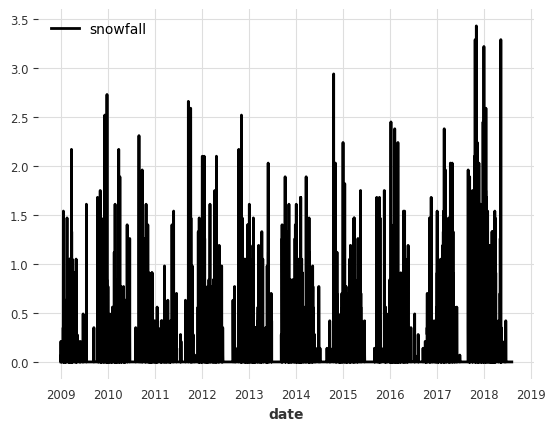

In [ ]:
y_train.plot()

In [ ]:
model.fit(
    series=y_train,
    past_covariates=X_train,
    val_series=y_val,
    val_past_covariates=X_val,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | criterion           | MSELoss             | 0      | eval 
1 | train_criterion     | MSELoss             | 0      | eval 
2 | val_criterion       | MSELoss             | 0      | eval 
3 | train_metrics      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=18` reached.


TransformerModel(output_chunk_shift=0, d_model=512, nhead=8, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=256, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=48, output_chunk_length=48, batch_size=64, n_epochs=18, nr_epochs_val_period=1, optimizer_kwargs={'lr': 0.00035130209945333885}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1}, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), model_name=snowfall_model, force_reset=True, random_state=42)

# Save Model

In [ ]:
model.save("latest_snowfall_model.pt")

## Make Predictions

In [ ]:
forecast = model.predict(n=48, past_covariates=X_train_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
forecast.values()

array([[ 3.08933072e-03],
       [-2.74100956e-03],
       [-1.94893579e-03],
       [ 6.16803453e-03],
       [ 1.75173136e-03],
       [-1.64134607e-02],
       [ 9.36053446e-03],
       [-3.13511887e-03],
       [-4.09306311e-03],
       [ 1.29213754e-02],
       [ 2.60516538e-04],
       [ 3.00734764e-03],
       [-1.28566239e-02],
       [-2.31404970e-02],
       [ 3.36325968e-03],
       [ 2.80658692e-02],
       [ 1.44592338e-02],
       [-7.71671067e-03],
       [-3.67795035e-04],
       [-7.68931077e-03],
       [-1.51406771e-02],
       [-3.74378744e-03],
       [-6.53318170e-03],
       [ 1.52931292e-03],
       [-6.68512091e-03],
       [-2.52998205e-02],
       [ 1.43243124e-02],
       [-1.63721810e-04],
       [-7.79233441e-02],
       [-1.09539944e-02],
       [ 1.33624146e-02],
       [ 4.34751962e-02],
       [ 3.70871235e-02],
       [ 4.21081646e-03],
       [-6.96227114e-02],
       [ 4.53435249e-02],
       [ 1.42035440e-02],
       [-3.44871799e-02],
       [-3.9

<Axes: xlabel='date'>

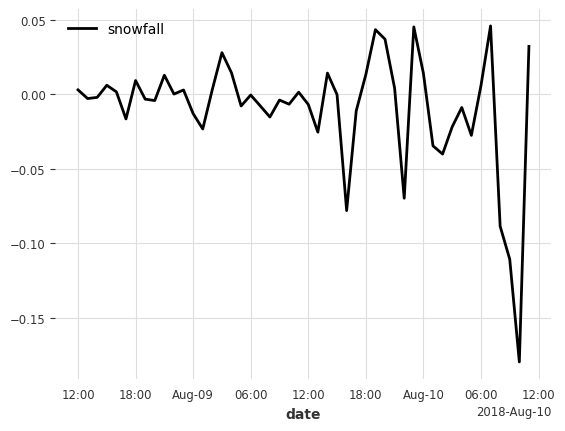

In [ ]:
forecast.plot()

## Backtesting and Historical Forecasting

In [ ]:
historical_forecast = model.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae = mae(snowfall_series.slice_intersect(historical_forecast), historical_forecast)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
error_mae

0.16374597586625178

# Plot historical forecast vs actuals

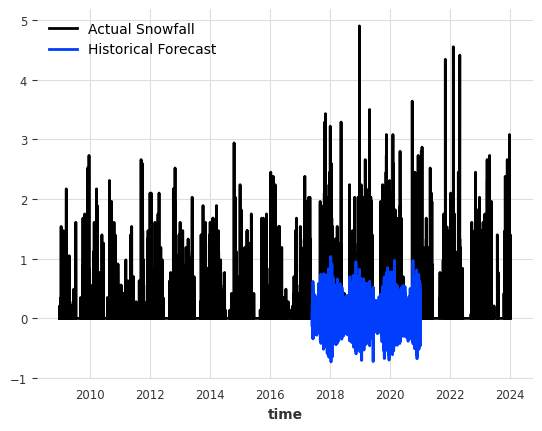

In [ ]:
snowfall_series.plot(label="Actual Snowfall")
historical_forecast.plot(label="Historical Forecast")
plt.legend()
plt.show();

## Backtest Snowfall Model

In [ ]:
backtest_mae = model.backtest(
    series=y_test,
    past_covariates=X_test,
    start=0.7,
    forecast_horizon=48,
    stride=10,
    retrain=False,
    metric=mae,
    verbose=True
)

print(f"Backtest MAE: {backtest_mae}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest MAE: 0.14341591898707987


# Load Model | Evaluate | Find "best" (haha) Model for now

In [ ]:
model1 = TransformerModel.load("/content/new_snowfall_model.pt")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
model1.predict(n=48, series=y_train_val, past_covariates=X_train_val).values()

ERROR:main_logger:ValueError: The provided past or future covariates must have dimensionality matching that of the covariates used for training the model.


ValueError: The provided past or future covariates must have dimensionality matching that of the covariates used for training the model.

In [ ]:
historical_forecast_1 = model1.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae1 = mae(snowfall_series.slice_intersect(historical_forecast_1), historical_forecast_1)
print(error_mae1)

snowfall_series.plot(label="Actual Snowfall")
historical_forecast_1.plot(label="Historical Forecast")
plt.legend()
plt.show();

ERROR:main_logger:ValueError: The provided past or future covariates must have dimensionality matching that of the covariates used for training the model.


ValueError: The provided past or future covariates must have dimensionality matching that of the covariates used for training the model.

In [ ]:
import torch
model2= TransformerModel.load("/content/snowfall_model.pt", map_location=torch.device('cpu'))

/usr/local/lib/python3.10/dist-packages/darts/models/forecasting/torch_forecasting_model.py:1747: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForecastingModel 

In [ ]:
historical_forecast_2 = model2.historical_forecasts(
    series=y_train_val,
    past_covariates=X_train_val,
    start=0.7,
    forecast_horizon=48,
    stride=1,
    retrain=False,
    overlap_end=True,
    verbose=True
)

error_mae1 = mae(snowfall_series.slice_intersect(historical_forecast_2), historical_forecast_2)
print(error_mae1)

snowfall_series.plot(label="Actual Snowfall")
historical_forecast_2.plot(label="Historical Forecast")
plt.legend()
plt.show();

ERROR:main_logger:ValueError: The provided past or future covariates must have dimensionality matching that of the covariates used for training the model.


ValueError: The provided past or future covariates must have dimensionality matching that of the covariates used for training the model.